In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization.wcsaxes import SphericalCircle

import corner

import os

import requests

import pickle

from help_functions import adjust_lightness

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/DESI/Targets/code/TF/')
from line_fits import param_invert, hyperfit_line

In [66]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 1.75
# V0 = 2.0
# V0 = 2.25
# V0 = 2.5

# Data

## fuji

In [4]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- CORI
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

## SGA

In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [6]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the fuji data into center and off-center observations

In [7]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [8]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [9]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

#### Are there any galaxies with multiple good center observations?

In [10]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
   6443
  10959
  12318
  16649
  26199
  28451
  37543
  46327
    ...
1363936
1364394
1365198
1366241
1374698
1380792
1382772
1386484
1392414
1401610
1418640
Length = 175 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [12]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

In [13]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

In [14]:
d_Coma = 10*10**(0.2*mu_Coma) # pc
V_Coma = 100*(d_Coma*1e-6) # km/s

V_Coma

7345.138681571143

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [15]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(d_Coma*1e-6))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(d_Coma*1e-6))*u.radian

In [16]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [17]:
SGA_in_Coma1 = (sep < R2t_Coma_angle_1p5) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= R2t_Coma_angle_1p5) & (sep < R2t_Coma_angle_3) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 275
fuji off-center observations in Coma: 909


# Calculate the rotational velocity

In [18]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

# Cut for Coma galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [19]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_inComa['V_ROT']) < 1000) & (np.abs(axis_inComa['V_ROT']) > 10)

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

193 113


## Relative velocity cut

In [20]:
good_deltaV = np.ones(len(good_axis_inComa), dtype=bool)

for sga_id in np.unique(good_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_inComa['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_inComa['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [21]:
good_deltaV_axis_inComa = good_axis_inComa[good_deltaV]

print(len(good_deltaV_axis_inComa), len(np.unique(good_deltaV_axis_inComa['SGA_ID'])))

185 110


## Inclination angle cut

In [22]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_inComa['iSGA'] = -1

for i in range(len(good_deltaV_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_inComa['SGA_ID'][i]]
    
    good_deltaV_axis_inComa['iSGA'][i] = sga_idx
    
good_deltaV_axis_inComa['cosi2'] = SGA['cosi2'][good_deltaV_axis_inComa['iSGA']]

In [23]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_deltaV_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

150 91


## Morphology cut

In [24]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [25]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
--
--
80 45


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [29]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

cache/coma_39627776214435213.jpg exists.
INFO:spectra.py:291:read_spectra: iotime 4.317 sec to read spectra-sv3-bright-26004.fits at 2022-09-02T16:10:03.413145


TypeError: 'AxesSubplot' object is not subscriptable

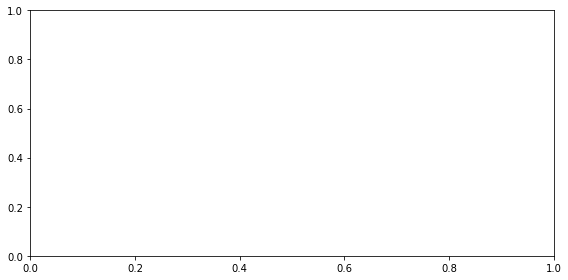

In [183]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break

In [26]:
VI_remove = Table.read('fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

80 45


# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [27]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [28]:
# Make a catalog of just those galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

# Christoph_removed = np.in1d(SGA_TF['SGA_ID'], [309306, 455486, 486394, 1167691, 1269260])

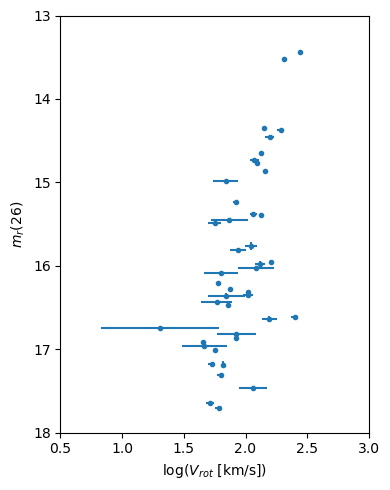

In [29]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.')
# plt.errorbar(np.log10(SGA_TF['V_0p33R26'][Christoph_removed]), 
#              SGA_TF['R_MAG_SB26'][Christoph_removed], 
#              xerr=0.434*SGA_TF['V_0p33R26_err'][Christoph_removed]/SGA_TF['V_0p33R26'][Christoph_removed],
#              yerr=SGA_TF['R_MAG_SB26_ERR'][Christoph_removed], 
#              fmt='.')

plt.xlim([0.5, 3])
plt.ylim([18, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Remove dwarf galaxies

This is to mimic the selection criteria used in the Cosmicflows-4 calibration, and is only possible after a full calibration has been done.  This is therefore an iterative process.

### First, calculate the absolute magnitudes for the galaxies based on the current TF calibration

\begin{equation}
  M_r = a(\log \left( V(0.33R_{26}) \right) - V_0) + b
\end{equation}
where
* $a = -7.53^{+1.03}_{-1.36} = -7.53\pm 1.29$ (from `Coma-Fuji-ITFR_KAD.ipynb`)
* $b = -22.28^{+0.16}_{-0.21} = -22.28\pm 0.20$ (from `fuji_zero-point_ITFR_KAD.ipynb`)

*(Updated 1/30/24)*

In [67]:
temp_infile = open('cov_ab_fuji_zero-point_ITFR_KAD-V0_' + str(V0) + '.pickle', 'rb')
cov_ab, itfr_samples, tfr_samples = pickle.load(temp_infile)
temp_infile.close()

In [68]:
our_slope = np.median(tfr_samples[0])

our_ZP = np.median(tfr_samples[1])

SGA_TF['R_ABSMAG_SB26'] = our_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + our_ZP

In [69]:
#N_samples = 10000

rng = np.random.default_rng()

#m_random = rng.normal(our_slope, our_slope_err, size=N_samples)
#b_random = rng.normal(our_ZP, our_ZP_err, size=N_samples)
#m_random, b_random = rng.multivariate_normal([our_slope, our_ZP], cov_ab, N_samples).T
m_random = tfr_samples[0]
b_random = tfr_samples[1]

N_samples = len(m_random)

SGA_TF['R_ABSMAG_SB26_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_TF['R_ABSMAG_SB26_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_416324/1250238674.py:19: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random) - V0) + b_random


### Filter out dwarf galaxies

Those with $M_r > -17$

In [70]:
dwarfs = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > -17

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

2


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these first "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.89^{+1.16}_{-1.62} = -7.89\pm 1.57$ (from this notebook)
* $-22.34^{+0.18}_{-0.25} = -22.34\pm 0.25$ (from `fuji_zero-point_ITFR_nodwarf_KAD.ipynb`)

*(Updated 1/30/24)*

In [80]:
temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf1_KAD-V0_' + str(V0) + '.pickle', 'rb')
cov_ab_bright, itfr_samples2, tfr_samples2 = pickle.load(temp_infile)
temp_infile.close()

In [81]:
our_bright_slope = np.median(tfr_samples2[0])
# our_bright_slope_err = 1.92

our_bright_ZP = np.median(tfr_samples2[1])
# our_bright_ZP_err = 0.29

SGA_TF['R_ABSMAG_SB26_bright'] = our_bright_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP

In [82]:
#m2_random = rng.normal(our_bright_slope, our_bright_slope_err, size=N_samples)
#b2_random = rng.normal(our_bright_ZP, our_bright_ZP_err, size=N_samples)
#m2_random, b2_random = rng.multivariate_normal([our_bright_slope, our_bright_ZP], cov_ab_bright, N_samples).T
m2_random = tfr_samples2[0]
b2_random = tfr_samples2[1]

N_samples = len(m2_random)

SGA_TF['R_ABSMAG_SB26_bright_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m2_random*(np.log10(v_random) - V0) + b2_random
    
    SGA_TF['R_ABSMAG_SB26_bright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_416324/1535855898.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m2_random*(np.log10(v_random) - V0) + b2_random


In [83]:
dwarfs2 = (SGA_TF['R_ABSMAG_SB26_bright'] - SGA_TF['R_ABSMAG_SB26_bright_err']) > -17

SGA_TF_bright2 = SGA_TF[~dwarfs2]

print(np.sum(dwarfs2))

1


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these second "dwarf" galaxies, the best-fit parameters for our TFR are
* $-7.53^{+1.19}_{-1.68} = -7.53\pm 1.65$ (from the second iteration in this notebook)
* $-22.28^{+0.18}_{-0.26} = -22.28\pm 0.26$ (from the second iteration in `fuji_zero-point_ITFR_nodwarf_KAD.ipynb`)

*(Updated 8/21/23)*

In [92]:
temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf2_KAD-V0_' + str(V0) + '.pickle', 'rb')
cov_ab_bright2, itfr_samples3, tfr_samples3 = pickle.load(temp_infile)
temp_infile.close()

our_bright_slope2 = np.median(tfr_samples3[0])
# our_bright_slope2_err = 1.65

our_bright_ZP2 = np.median(tfr_samples3[1])
# our_bright_ZP2_err = 0.26

SGA_TF['R_ABSMAG_SB26_bright2'] = our_bright_slope2 * (np.log10(SGA_TF['V_0p33R26']) - V0) + our_bright_ZP2

In [95]:
#m3_random = rng.normal(our_bright_slope2, our_bright_slope2_err, size=N_samples)
#b3_random = rng.normal(our_bright_ZP2, our_bright_ZP2_err, size=N_samples)
#m3_random, b3_random = rng.multivariate_normal([our_bright_slope2, our_bright_ZP2], cov_ab_bright2, N_samples).T
m3_random = tfr_samples3[0]
b3_random = tfr_samples3[1]

N_samples = len(m3_random)

SGA_TF['R_ABSMAG_SB26_bright2_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m3_random * (np.log10(v_random) - V0) + b3_random
    
    SGA_TF['R_ABSMAG_SB26_bright2_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_416324/3912130667.py:15: RuntimeWarning: invalid value encountered in log10
  Ms = m3_random * (np.log10(v_random) - V0) + b3_random


In [96]:
dwarfs3 = (SGA_TF['R_ABSMAG_SB26_bright2'] - SGA_TF['R_ABSMAG_SB26_bright2_err']) > -17

SGA_TF_bright3 = SGA_TF[~dwarfs3]

print(np.sum(dwarfs3))

2


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these third "dwarf" galaxies, the best-fit parameters for our TFR are
* $-8.55^{+1.40}_{-1.98}$ (from the third iteration in this notebook)
* $-18.19\pm 0.64$ (from the third iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [80]:
our_bright_slope3 = -8.55
our_bright_slope3_err = 1.87

our_bright_ZP3 = -18.19
our_bright_ZP3_err = 0.64

SGA_TF['R_ABSMAG_SB26_bright3'] = our_bright_slope3 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP3

In [81]:
m4_random = rng.normal(our_bright_slope3, our_bright_slope3_err, size=N_samples)
b4_random = rng.normal(our_bright_ZP3, our_bright_ZP3_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright3_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m4_random * (np.log10(v_random) - 2.) + b4_random
    
    SGA_TF['R_ABSMAG_SB26_bright3_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/1383774645.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m4_random * (np.log10(v_random) - 2.) + b4_random


In [82]:
dwarfs4 = (SGA_TF['R_ABSMAG_SB26_bright3'] - SGA_TF['R_ABSMAG_SB26_bright3_err']) > -17

SGA_TF_bright4 = SGA_TF[~dwarfs4]

print(np.sum(dwarfs4))

8


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these fourth "dwarf" galaxies, the best-fit parameters for our TFR are
* $-8.95^{+1.64}_{-2.25}$ (from the fourth iteration in this notebook)
* $-18.06\pm 0.72$ (from the fourth iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [100]:
our_bright_slope4 = -8.95
our_bright_slope4_err = 2.10

our_bright_ZP4 = -18.06
our_bright_ZP4_err = 0.72

SGA_TF['R_ABSMAG_SB26_bright4'] = our_bright_slope4 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP4

In [101]:
m5_random = rng.normal(our_bright_slope4, our_bright_slope4_err, size=N_samples)
b5_random = rng.normal(our_bright_ZP4, our_bright_ZP4_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright4_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m5_random * (np.log10(v_random) - 2.) + b5_random
    
    SGA_TF['R_ABSMAG_SB26_bright4_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/4104580723.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m5_random * (np.log10(v_random) - 2.) + b5_random


In [102]:
dwarfs5 = (SGA_TF['R_ABSMAG_SB26_bright4'] - SGA_TF['R_ABSMAG_SB26_bright4_err']) > -17

SGA_TF_bright5 = SGA_TF[~dwarfs5]

print(np.sum(dwarfs5))

10


#### Do we need to iterate through this again?

After factoring in the uncertainties before removing these fifth "dwarf" galaxies, the best-fit parameters for our TFR are
* $-9.68^{+1.89}_{-2.94}$ (from the fifth iteration in this notebook)
* $-17.80\pm 0.97$ (from the fifth iteration in `fuji_zero-point_nodwarf_KAD.ipynb`)

In [111]:
our_bright_slope5 = -9.68
our_bright_slope5_err = 2.82

our_bright_ZP5 = -17.80
our_bright_ZP5_err = 0.97

SGA_TF['R_ABSMAG_SB26_bright5'] = our_bright_slope5 * (np.log10(SGA_TF['V_0p33R26']) - 2.) + our_bright_ZP5

In [112]:
m6_random = rng.normal(our_bright_slope5, our_bright_slope5_err, size=N_samples)
b6_random = rng.normal(our_bright_ZP5, our_bright_ZP5_err, size=N_samples)

SGA_TF['R_ABSMAG_SB26_bright5_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m6_random * (np.log10(v_random) - 2.) + b6_random
    
    SGA_TF['R_ABSMAG_SB26_bright5_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_3745/1876344261.py:10: RuntimeWarning: invalid value encountered in log10
  Ms = m6_random * (np.log10(v_random) - 2.) + b6_random


In [113]:
dwarfs6 = (SGA_TF['R_ABSMAG_SB26_bright5'] - SGA_TF['R_ABSMAG_SB26_bright5_err']) > -17

SGA_TF_bright6 = SGA_TF[~dwarfs6]

print(np.sum(dwarfs6))

10


## Fit the ITFR using `hyperfit`

In [35]:
bounds = ((-1000.0, 1000.0), (-10.0, 10.0), (1.0e-5, 500.0))

### First iteration

Using `dwarfs` sample

In [71]:
w0, w1, sig_w, cov_w, mcmc_samples, hf = hyperfit_line(SGA_TF_bright['R_MAG_SB26'], 
                                                       np.log10(SGA_TF_bright['V_0p33R26']) - V0, 
                                                       SGA_TF_bright['R_MAG_SB26_ERR'], 
                                                       0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26'], 
                                                       bounds)

     fun: -55.857019142146854
     jac: array([ 0.00772076, -0.00273701, -0.05587637])
 message: 'Optimization terminated successfully.'
    nfev: 3751
     nit: 82
 success: True
       x: array([0.25941071, 2.14176883, 0.13635515])


100%|██████████| 1000/1000 [00:00<00:00, 1648.40it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.83402691 67.15311952 33.29438549] / 3357.655975849025


100%|██████████| 1000/1000 [00:00<00:00, 2073.65it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [94.55876278 94.56845401 53.31923114] / 4728.422700460811


100%|██████████| 1000/1000 [00:00<00:00, 1944.83it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [102.5743251  102.02930868  54.3405048 ] / 5128.7162548315055


100%|██████████| 1000/1000 [00:00<00:00, 2076.56it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [102.86149105 100.91762803  55.98996105] / 5143.074552451171


100%|██████████| 1000/1000 [00:00<00:00, 2085.64it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [137.69765118 141.77011952  71.13758469] / 7088.505975886625


100%|██████████| 1000/1000 [00:00<00:00, 2078.09it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [177.54544614 184.98783643  88.89912719] / 9249.391821346795


100%|██████████| 1000/1000 [00:00<00:00, 1995.89it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [183.33548451 191.15013042  85.59265951] / 9557.506521085914


100%|██████████| 1000/1000 [00:00<00:00, 1938.83it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [183.24037111 190.3572336   79.32844129] / 9517.86167981449


100%|██████████| 1000/1000 [00:00<00:00, 2036.72it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [200.46943846 209.72247528  74.28367623] / 10486.123764155354


100%|██████████| 1000/1000 [00:00<00:00, 1658.09it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [236.7152858  248.34011771  77.48999597] / 12417.005885699542


100%|██████████| 1000/1000 [00:00<00:00, 1465.57it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [217.58753111 230.61352085  77.43554793] / 11530.67604237502


100%|██████████| 1000/1000 [00:00<00:00, 1583.43it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [225.66810636 240.30398602  68.08051471] / 12015.199301219765


100%|██████████| 1000/1000 [00:00<00:00, 1535.21it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [216.47082091 235.80343491  63.97621732] / 11790.171745743273


100%|██████████| 1000/1000 [00:00<00:00, 1672.09it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [194.95193355 207.57871205  65.54184902] / 10378.935602513622


100%|██████████| 1000/1000 [00:00<00:00, 1298.86it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [177.76073764 185.08277374  65.99818367] / 9254.13868720446


100%|██████████| 1000/1000 [00:00<00:00, 1210.48it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [175.55303774 181.17113101  66.2981079 ] / 9058.556550364987


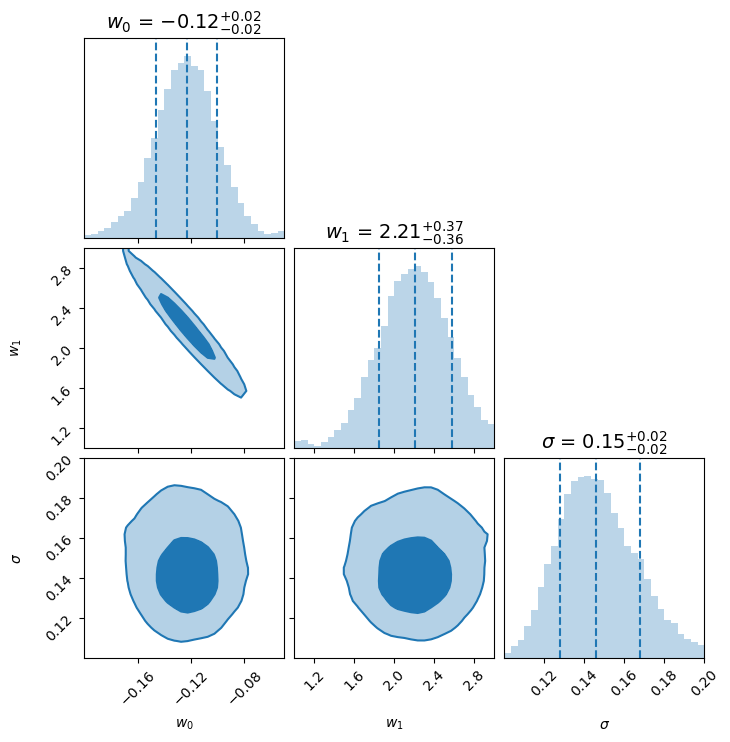

In [72]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
                    # range=[[-0.2, -0.05], [0, 3], [0.1, 0.2]],   # Range for w0, w1, sigma. Adjust as needed.
                    range=[[-0.2, -0.05], [1, 3], [0.1, 0.2]],
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 1st iteration'},
                    title_kwargs={"fontsize": 14})

In [73]:
a_itfr, b_itfr, cov_itfr = param_invert(w0, w1, cov_w[:2,:2])

print(f'         w0: {w0:.3f} +/- {np.sqrt(cov_w[0,0]):.3f}')
print(f'         w1:  {w1:.2f}  +/- {np.sqrt(cov_w[1,1]):.2f}')
print(f'      slope: {a_itfr:.2f}  +/- {np.sqrt(cov_itfr[0,0]):.2f}')
print(f'y-intercept: {b_itfr:.2f}  +/- {np.sqrt(cov_itfr[1,1]):.2f}')

         w0: -0.123 +/- 0.024
         w1:  2.21  +/- 0.39
      slope: -8.11  +/- 1.99
y-intercept: 17.90  +/- 0.55


In [74]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples = np.zeros(mcmc_samples.shape)

tfr_mcmc_samples[0] = 1./mcmc_samples[0]
tfr_mcmc_samples[1] = -mcmc_samples[1]/mcmc_samples[0]
tfr_mcmc_samples[2] = mcmc_samples[2]

In [75]:
temp_outfile = open('mcmc_fuji_Coma_ITFR_nodwarfs1_KAD-V0_' + str(V0) + '.pickle', 'wb')
pickle.dump((cov_w, cov_itfr, mcmc_samples, tfr_mcmc_samples), temp_outfile)
temp_outfile.close()

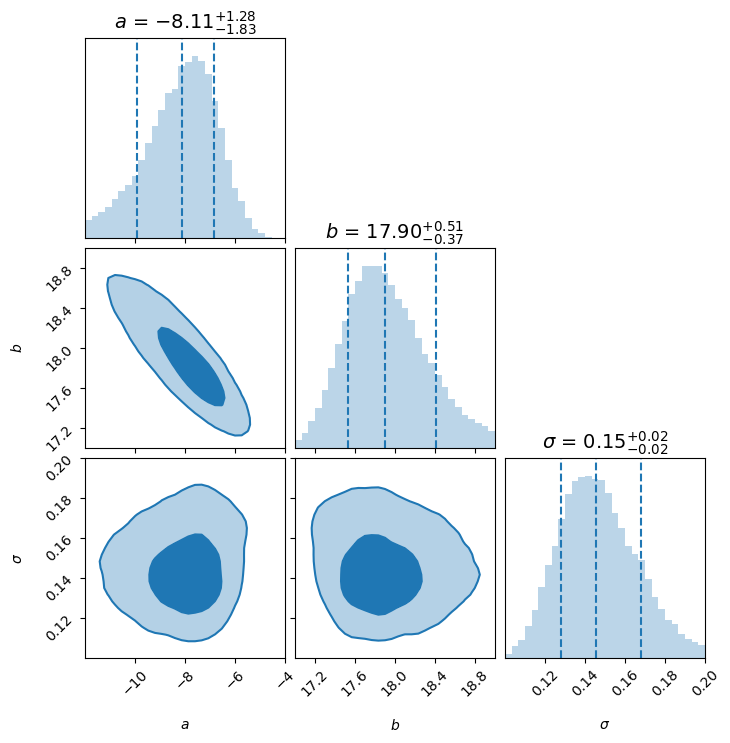

In [78]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    # range=[[-12, -4], [10, 14], [0.1, 0.2]],   # Range for a, b, sigma. Adjust as needed.
                    # range=[[-12, -4], [15, 17], [0.1, 0.2]],  # V0 = 2.0
                    # range=[[-12, -4], [13, 15], [0.1, 0.2]],  # V0 = 2.25
                    range=[[-12, -4], [17, 19], [0.1, 0.2]],  # V0 = 1.75
                    labels=['$a$', '$b$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 1st iteration'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_nodwarf1_20240130.png', dpi=150)

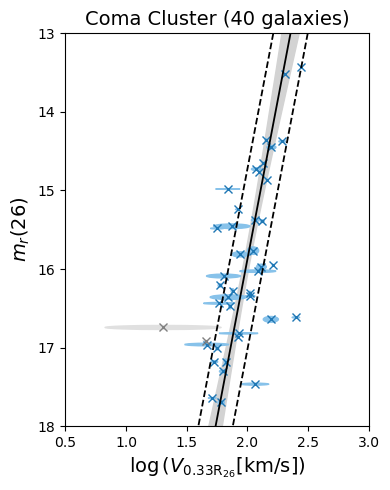

In [79]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a_itfr * (xvals - V0) + b_itfr

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26']
y_err = SGA_TF_bright['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs]), SGA_TF['R_MAG_SB26'][dwarfs]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs]/SGA_TF['V_0p33R26'][dwarfs]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color(adjust_lightness('gray', amount=1.75))
ax.plot(data[0], data[1], 'x')
ax.plot(data_removed[0], data_removed[1], 'x', c='gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright)), fontsize = 14)
ax.set_xlim(0.5, 3)
ax.set_ylim(18, 13);

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_nodwarfs1_20240130.png', dpi=150, facecolor='none');

### Second iteration

Using `dwarfs2` sample

In [84]:
w0_2, w1_2, sig_w_2, cov_w_2, mcmc_samples2, hf2 = hyperfit_line(SGA_TF_bright2['R_MAG_SB26'], 
                                                                 np.log10(SGA_TF_bright2['V_0p33R26']) - V0, 
                                                                 SGA_TF_bright2['R_MAG_SB26_ERR'], 
                                                                 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26'], 
                                                                 bounds)

     fun: -56.67111177225138
     jac: array([-0.05034195,  0.00993339, -0.04955751])
 message: 'Optimization terminated successfully.'
    nfev: 3117
     nit: 68
 success: True
       x: array([0.27933291, 2.21285404, 0.13930644])


100%|██████████| 1000/1000 [00:00<00:00, 1379.70it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [81.49722488 81.48781793 28.53717014] / 4074.8612439822737


100%|██████████| 1000/1000 [00:00<00:00, 2010.90it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [94.44488291 95.47489733 53.39435052] / 4773.7448663925325


100%|██████████| 1000/1000 [00:00<00:00, 1194.83it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [100.45719465 101.2360238   53.19929632] / 5061.801189922913


100%|██████████| 1000/1000 [00:00<00:00, 1348.67it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [108.85697291 110.90754236  57.45143541] / 5545.377117766733


100%|██████████| 1000/1000 [00:00<00:00, 1912.83it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [142.5807318  147.68475675  60.79587829] / 7384.237837705096


100%|██████████| 1000/1000 [00:00<00:00, 1594.22it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.92564013 129.75204845  51.55072414] / 6487.602422628575


100%|██████████| 1000/1000 [00:00<00:00, 1181.14it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [111.14858528 111.59678556  47.37807281] / 5579.839278066066


100%|██████████| 1000/1000 [00:00<00:00, 1489.97it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [112.75707087 114.40832948  43.08475787] / 5720.416474082926


100%|██████████| 1000/1000 [00:00<00:00, 2008.95it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [126.79163799 131.40458316  47.55329907] / 6570.229158076778


100%|██████████| 1000/1000 [00:00<00:00, 1794.46it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.56172778 154.59098138  55.18398931] / 7729.54906913439


100%|██████████| 1000/1000 [00:00<00:00, 1191.30it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [134.64675331 137.56852929  58.48030142] / 6878.426464359616


100%|██████████| 1000/1000 [00:00<00:00, 1507.57it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [144.95905287 146.04495616  57.48394832] / 7302.247807847274


100%|██████████| 1000/1000 [00:00<00:00, 2008.18it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [164.23152117 170.35923876  58.09915134] / 8517.961938150493


100%|██████████| 1000/1000 [00:00<00:00, 1985.61it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.39635713 169.46633036  63.41254196] / 8473.316518179177


100%|██████████| 1000/1000 [00:00<00:00, 1848.77it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [175.38100073 188.50924664  62.32608049] / 9425.46233205274


100%|██████████| 1000/1000 [00:00<00:00, 1844.87it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [175.5259325  187.5203827   65.37943268] / 9376.019134939908


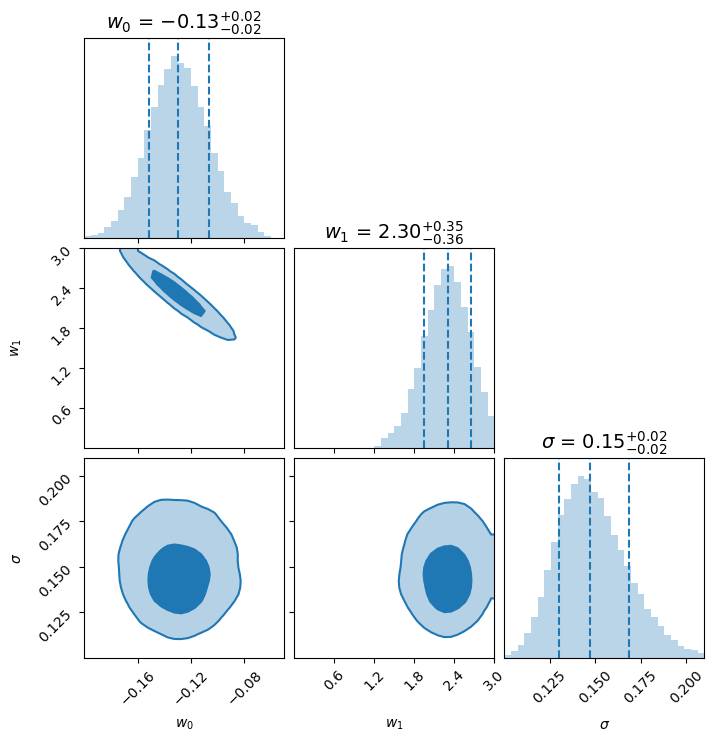

In [85]:
fig = corner.corner(mcmc_samples2.T, bins=30, smooth=1,
                    range=[[-0.2, -0.05], [0, 3], [0.1, 0.21]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_1$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Coma w/o dwarfs, 2nd iteration'},
                    title_kwargs={"fontsize": 14})

In [86]:
a2, b2, cov2 = param_invert(w0_2, w1_2, cov_w_2[:2,:2])

print(f'         w0: {w0_2:.3f} +/- {np.sqrt(cov_w_2[0,0]):.3f}')
print(f'         w1:  {w1_2:.2f}  +/- {np.sqrt(cov_w_2[1,1]):.2f}')
print(f'      slope: {a2:.2f}  +/- {np.sqrt(cov2[0,0]):.2f}')
print(f'y-intercept: {b2:.2f}  +/- {np.sqrt(cov2[1,1]):.2f}')

         w0: -0.129 +/- 0.022
         w1:  2.30  +/- 0.36
      slope: -7.73  +/- 1.54
y-intercept: 17.76  +/- 0.42


In [87]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples2 = np.zeros(mcmc_samples2.shape)

tfr_mcmc_samples2[0] = 1./mcmc_samples2[0]
tfr_mcmc_samples2[1] = -mcmc_samples2[1]/mcmc_samples2[0]
tfr_mcmc_samples2[2] = mcmc_samples2[2]

In [88]:
temp_outfile = open('mcmc_fuji_Coma_ITFR_nodwarfs2_KAD-V0_' + str(V0) + '.pickle', 'wb')
pickle.dump((cov_w_2, cov2, mcmc_samples2, tfr_mcmc_samples2), temp_outfile)
temp_outfile.close()

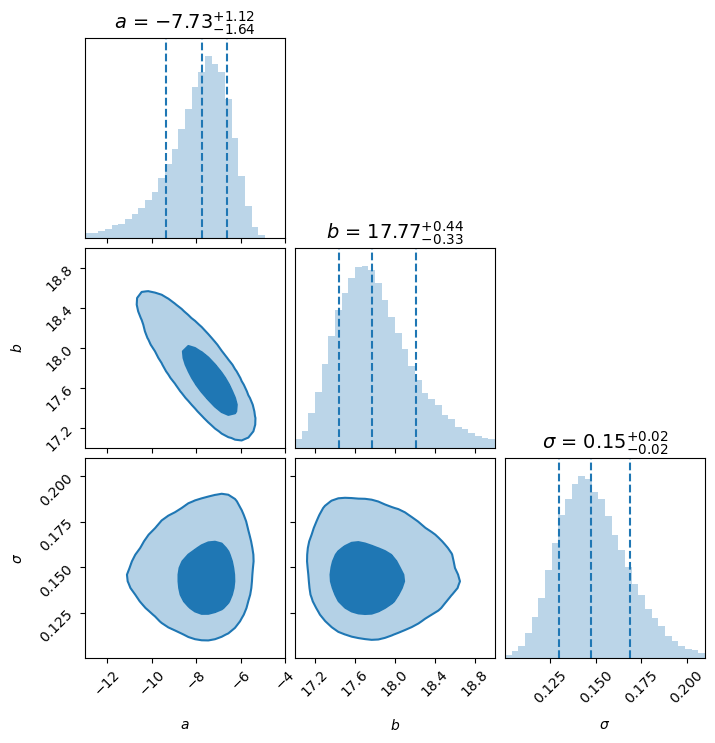

In [90]:
fig = corner.corner(tfr_mcmc_samples2.T, bins=30, smooth=1,
             # range=[[-13, -4], [10, 14], [0.1, 0.21]],   # Range for a, b, sigma. Adjust as needed.
                    range=[[-13, -4], [17, 19], [0.1, 0.21]], # V0 = 1.75
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma w/o dwarfs, 2nd iteration'},
             title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_nodwarf2_20230821.png', dpi=150)

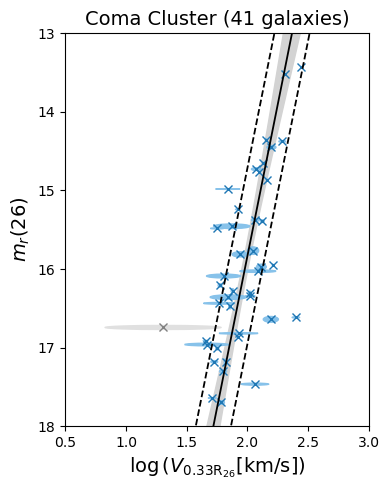

In [91]:
sigmas = hf2.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a2 * (xvals - V0) + b2

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - V0, tfr_mcmc_samples2[0]) + tfr_mcmc_samples2[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright2['V_0p33R26']), SGA_TF_bright2['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26']
y_err = SGA_TF_bright2['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs2]), SGA_TF['R_MAG_SB26'][dwarfs2]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs2]/SGA_TF['V_0p33R26'][dwarfs2]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs2]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color(adjust_lightness('gray', amount=1.75))
ax.plot(data[0], data[1], 'x')
ax.plot(data_removed[0], data_removed[1], 'x', c='gray')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals - hf2.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals + hf2.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright2)), fontsize = 14)
ax.set_xlim(0.5, 3)
ax.set_ylim(18, 13);

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_nodwarf2_20230821.png', dpi=150)

### Third iteration

Using `dwarfs3` sample

#### Create covariance matrix for `hyperfit`

In [70]:
Ndata = len(SGA_TF_bright3)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright3['V_0p33R26_err'][i]/SGA_TF_bright3['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright3['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [71]:
hf = LinFit([np.log10(SGA_TF_bright3['V_0p33R26']) - 2., SGA_TF_bright3['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [72]:
bounds3 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples3, mcmc_lnlike3 = hf.emcee(bounds3, verbose=True)

print(np.mean(mcmc_samples3, axis=1), np.std(mcmc_samples3, axis=1))

     fun: -53.31782360193888
     jac: array([-0.00239524,  0.00775842, -0.04957172])
 message: 'Optimization terminated successfully.'
    nfev: 6901
     nit: 152
 success: True
       x: array([1.78805074, 0.20446296, 0.14349157])


100%|██████████| 1000/1000 [00:00<00:00, 2094.61it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [68.56160146 67.64403952 46.60340999] / 3428.08007296617


100%|██████████| 1000/1000 [00:00<00:00, 2005.24it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.26512865 95.95179907 50.07532064] / 4963.256432661015


100%|██████████| 1000/1000 [00:00<00:00, 2145.01it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.19538145 115.08285237  59.66780607] / 5809.769072723758


100%|██████████| 1000/1000 [00:00<00:00, 2163.07it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [113.59585234 111.44427506  52.95566869] / 5679.792616848697


100%|██████████| 1000/1000 [00:00<00:00, 2146.22it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.17381878 119.02153667  56.25175319] / 5951.0768336989395


100%|██████████| 1000/1000 [00:00<00:00, 2120.38it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [107.62139397 107.31947129  49.45944824] / 5381.069698574364


100%|██████████| 1000/1000 [00:00<00:00, 2256.54it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.38168315 122.69617626  54.48107849] / 6169.084157412179


100%|██████████| 1000/1000 [00:00<00:00, 2167.26it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [127.93796139 126.50954067  71.72451244] / 6396.898069727015


100%|██████████| 1000/1000 [00:00<00:00, 2203.75it/s]

Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.673163   127.3851263   71.18178396] / 6433.6581499492795
[-8.86975757 15.85320082  1.37260715] [1.86618276 0.24105652 0.35367101]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [73]:
a3, b3, sig3    = np.median(mcmc_samples3, axis=1)
da3, db3, dsig3 = np.std(mcmc_samples3, axis=1)

for val, err in zip((a3, b3, sig3), (da3, db3, dsig3)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -8.55 +/- 1.87
 15.85 +/- 0.24
  1.30 +/- 0.35


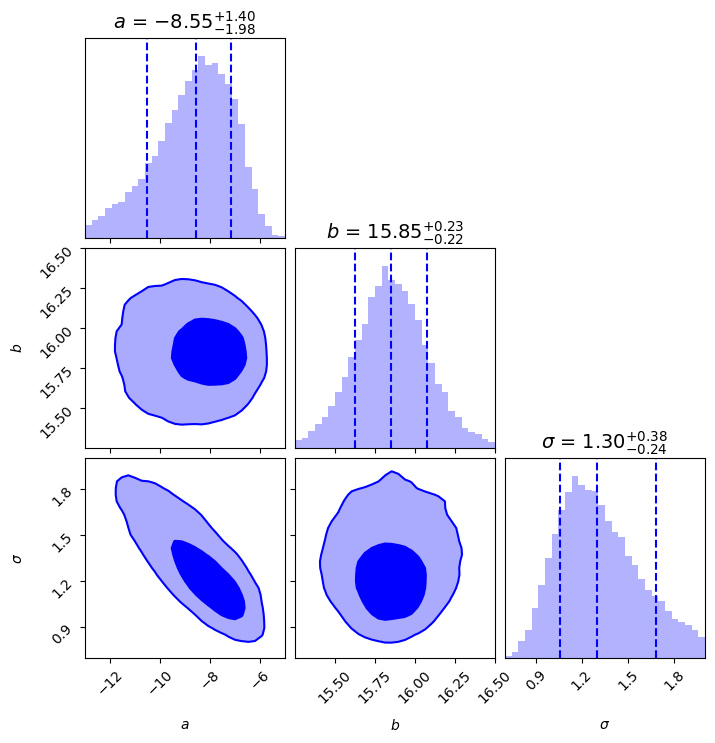

In [77]:
fig = corner.corner(mcmc_samples3.T, bins=30, smooth=1,
             range=[[-13, -5], [15.25, 16.5], [0.7, 2]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

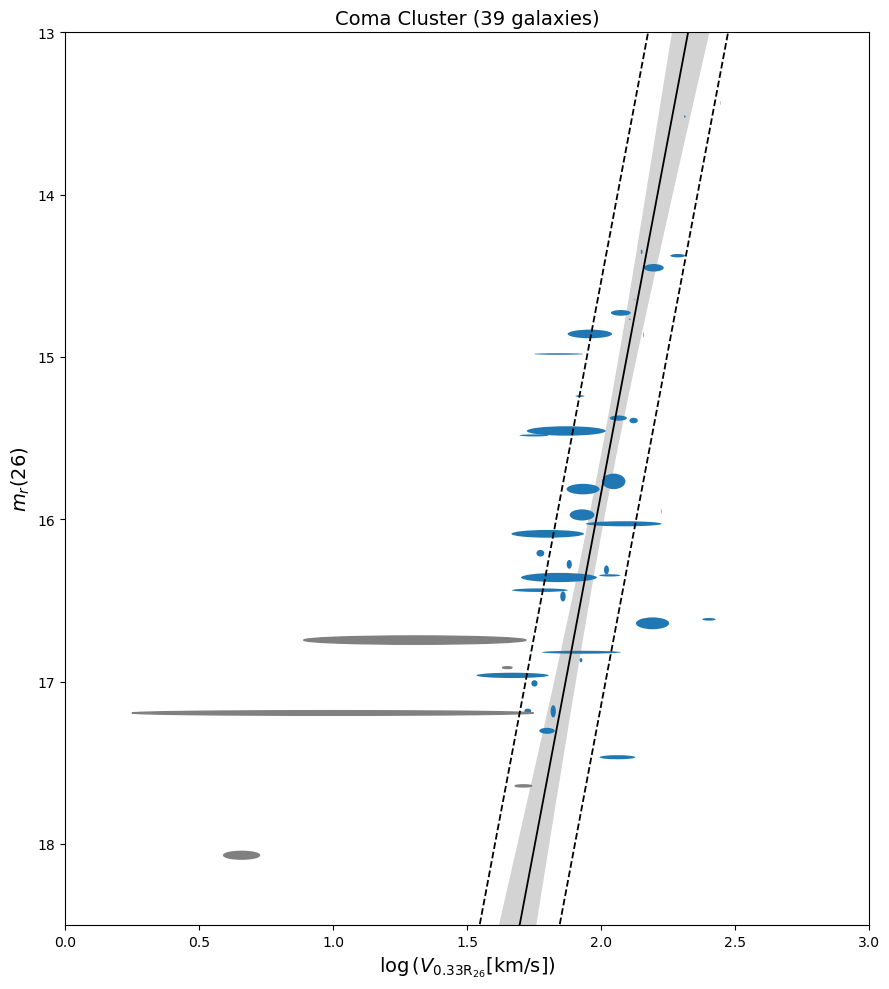

In [79]:
sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = hf.coords[0] * (xvals - 2.) + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals - 2., mcmc_samples3[0]) + mcmc_samples3[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [np.log10(SGA_TF_bright3['V_0p33R26']), SGA_TF_bright3['R_MAG_SB26']]
x_err = 0.434*SGA_TF_bright3['V_0p33R26_err']/SGA_TF_bright3['V_0p33R26']
y_err = SGA_TF_bright3['R_MAG_SB26_ERR']
corr_xy = np.zeros_like(x_err)

# Removed galaxies
data_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs3]), SGA_TF['R_MAG_SB26'][dwarfs3]]
x_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs3]/SGA_TF['V_0p33R26'][dwarfs3]
y_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs3]
corr_xy_removed = np.zeros_like(x_err_removed)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]
ells_removed = [
    Ellipse(
        xy=[data_removed[0][i], data_removed[1][i]],
        width=2*y_err_removed[i],
        height=2*x_err_removed[i],
        angle=np.rad2deg(np.arccos(corr_xy_removed[i])),
    )
    for i in range(len(data_removed[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(9,10), tight_layout=True)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    #e.set_color(cm.winter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    #e.set_alpha(0.9)
for i, e in enumerate(ells_removed):
    ax.add_artist(e)
    e.set_color('gray')
    #e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)
ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF_bright3)), fontsize = 14)
ax.set_xlim(0, 3)
ax.set_ylim(18.5, 13);

#plt.savefig('../../Figures/SV/fuji_Coma_TFR_20221013.png', dpi=150)

### Fourth iteration

Using `dwarfs4` sample

#### Create covariance matrix for `hyperfit`

In [83]:
Ndata = len(SGA_TF_bright4)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright4['V_0p33R26_err'][i]/SGA_TF_bright4['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright4['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [84]:
hf = LinFit([np.log10(SGA_TF_bright4['V_0p33R26']) - 2., SGA_TF_bright4['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [85]:
bounds4 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples4, mcmc_lnlike4 = hf.emcee(bounds4, verbose=True)

print(np.mean(mcmc_samples4, axis=1), np.std(mcmc_samples4, axis=1))

     fun: -50.31387763536259
     jac: array([ 0.01655422, -0.06870096,  0.00218705])
 message: 'Optimization terminated successfully.'
    nfev: 4708
     nit: 103
 success: True
       x: array([1.67106852, 0.17635771, 0.13733783])


100%|██████████| 1000/1000 [00:00<00:00, 2287.79it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [68.03920542 67.65975818 56.76266765] / 3401.960271198968


100%|██████████| 1000/1000 [00:00<00:00, 2208.41it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [107.67836055 105.98777517  54.35560747] / 5383.918027513124


100%|██████████| 1000/1000 [00:00<00:00, 2255.87it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.21502631 99.8540315  54.7632976 ] / 4992.701575069644


100%|██████████| 1000/1000 [00:00<00:00, 2264.49it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.72989946 96.97522597 51.59061647] / 4986.49497314253


100%|██████████| 1000/1000 [00:00<00:00, 2129.33it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [93.85713852 90.59504699 60.31451945] / 4692.856926131069


100%|██████████| 1000/1000 [00:00<00:00, 2263.62it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.79075159 136.45772038  55.8290806 ] / 7039.537579329211


100%|██████████| 1000/1000 [00:00<00:00, 2182.30it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [211.2779055  206.84383238  60.35692816] / 10563.895274848348


100%|██████████| 1000/1000 [00:00<00:00, 2249.69it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [189.14201095 186.83112337  65.72840228] / 9457.10054739703


100%|██████████| 1000/1000 [00:00<00:00, 2212.01it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [186.73530094 185.34296515  68.01870499] / 9336.765046842635


100%|██████████| 1000/1000 [00:00<00:00, 2260.85it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.88033796 192.79296215  62.86279957] / 9639.648107375633


100%|██████████| 1000/1000 [00:00<00:00, 2168.05it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [194.96101281 194.69588231  64.54452733] / 9748.050640358486
[-9.26552023 16.00471773  1.37514317] [2.10401192 0.26634535 0.36962178]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [99]:
a4, b4, sig4    = np.median(mcmc_samples4, axis=1)
da4, db4, dsig4 = np.std(mcmc_samples4, axis=1)

for val, err in zip((a4, b4, sig4), (da4, db4, dsig4)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -8.95 +/- 2.10
 15.99 +/- 0.27
  1.30 +/- 0.37


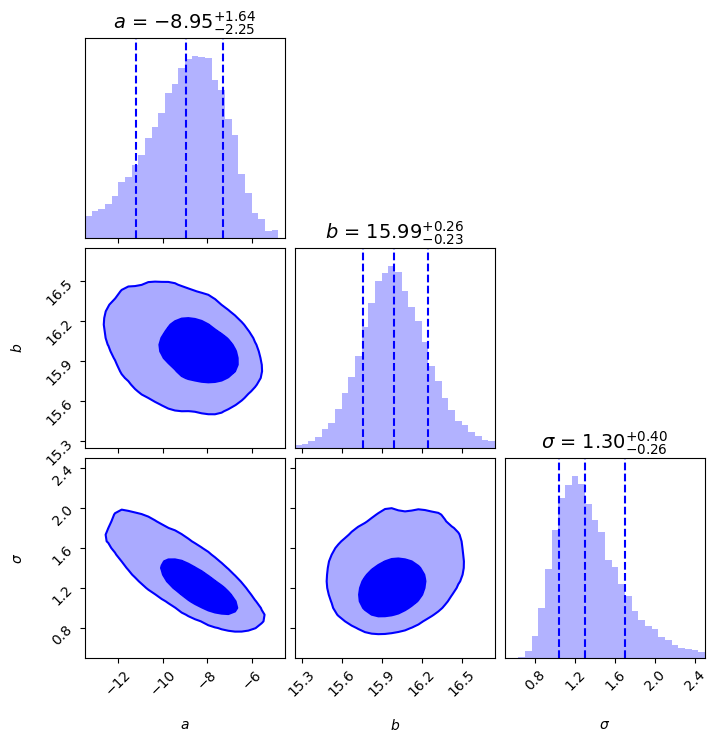

In [91]:
fig = corner.corner(mcmc_samples4.T, bins=30, smooth=1,
             range=[[-13.5, -4.5], [15.25, 16.75], [0.5, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)

### Fifth iteration

Using `dwarfs5` sample

#### Create covariance matrix for `hyperfit`

In [103]:
Ndata = len(SGA_TF_bright5)
cov = np.empty((2, 2, Ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i in range(Ndata):
    cov[:,:,i] = np.array([[(0.434*SGA_TF_bright5['V_0p33R26_err'][i]/SGA_TF_bright5['V_0p33R26'][i])**2, 0.], 
                           [0., SGA_TF_bright5['R_MAG_SB26_ERR'][i]**2]])

#### Create `hyperfit` object

In [104]:
hf = LinFit([np.log10(SGA_TF_bright5['V_0p33R26']) - 2., SGA_TF_bright5['R_MAG_SB26']], cov)

#### Run MCMC to fit TFR

In [105]:
bounds5 = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))

mcmc_samples5, mcmc_lnlike5 = hf.emcee(bounds5, verbose=True)

print(np.mean(mcmc_samples5, axis=1), np.std(mcmc_samples5, axis=1))

     fun: -48.68105983796883
     jac: array([ 0.00243858,  0.0049468 , -0.00932729])
 message: 'Optimization terminated successfully.'
    nfev: 7040
     nit: 155
 success: True
       x: array([1.5517684 , 0.1503824 , 0.13236643])


100%|██████████| 1000/1000 [00:00<00:00, 2285.22it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.31885899 64.59977796 45.57150876] / 3229.988898242772


100%|██████████| 1000/1000 [00:00<00:00, 2199.47it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.86030481 110.71432671  53.75784727] / 5543.0152407348305


100%|██████████| 1000/1000 [00:00<00:00, 2301.37it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.75172659 145.96174543  52.3873728 ] / 7487.5863292956765


100%|██████████| 1000/1000 [00:00<00:00, 2203.46it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.71015617 156.50587747  60.11999205] / 7835.507808636918


100%|██████████| 1000/1000 [00:00<00:00, 2349.13it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [182.21271785 179.59944327  64.71414446] / 9110.635892690509


100%|██████████| 1000/1000 [00:00<00:00, 2230.75it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [195.08892902 191.15233048  68.59877375] / 9754.44645093459


100%|██████████| 1000/1000 [00:00<00:00, 2269.60it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.28945113 174.59022251  63.56440374] / 8729.511125391793


100%|██████████| 1000/1000 [00:00<00:00, 2179.16it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [229.50231831 228.18389845  66.87361421] / 11475.115915346169


100%|██████████| 1000/1000 [00:00<00:00, 2219.40it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [217.50653647 215.71407385  65.71647347] / 10875.326823540241


100%|██████████| 1000/1000 [00:00<00:00, 2317.25it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [263.15422925 255.5412686   66.30916608] / 13157.711462743031


100%|██████████| 1000/1000 [00:00<00:00, 2148.58it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [281.2414003  273.71332018  65.69520555] / 14062.070014865447


100%|██████████| 1000/1000 [00:00<00:00, 2174.32it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [286.55393768 280.30472568  68.8496102 ] / 14327.696883963261


100%|██████████| 1000/1000 [00:00<00:00, 2246.23it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [273.43631091 265.30683448  64.83661488] / 13671.815545261783


100%|██████████| 1000/1000 [00:00<00:00, 2234.31it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [253.04379252 248.33811786  66.79385299] / 12652.189626087258


100%|██████████| 1000/1000 [00:00<00:00, 2137.61it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [240.70829715 232.88105289  66.11153072] / 12035.414857543921


100%|██████████| 1000/1000 [00:00<00:00, 2177.60it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [235.91006904 227.9287405   67.4460321 ] / 11795.503451821307
[-10.25240964  16.15874964   1.47558952] [2.82324216 0.32166154 0.47033494]


#### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [106]:
a5, b5, sig5    = np.median(mcmc_samples5, axis=1)
da5, db5, dsig5 = np.std(mcmc_samples5, axis=1)

for val, err in zip((a5, b5, sig5), (da5, db5, dsig5)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -9.68 +/- 2.82
 16.13 +/- 0.32
  1.37 +/- 0.47


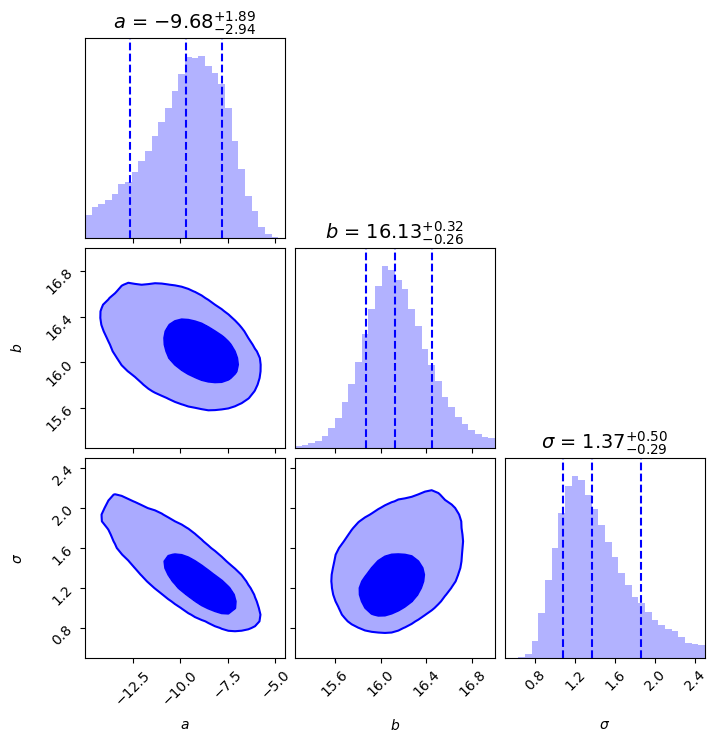

In [110]:
fig = corner.corner(mcmc_samples5.T, bins=30, smooth=1,
             range=[[-15, -4.5], [15.25, 17], [0.5, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 14})

#fig.savefig('../../Figures/SV/fuji_Coma_corner_20221013.png', dpi=150)